# Code Overview
We'll try and explain what we can here...

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import numpy as np
import json
import pickle
from prediction_pipeline.model_shap_explainer import build_explainer

plt.style.use('https://pltstyle.s3.eu-west-1.amazonaws.com/zinc.mplstyle')
#plt.style.use('https://pltstyle.s3.eu-west-1.amazonaws.com/light-gray.mplstyle')

plt.rcParams["font.family"] = "DM Mono"

# Player Weights
The method to determine player rankings goes through a series of training steps, ultimately using a `ridge regression` model. For every position, we evaluated the different stats that makes up each position (rushing, passing, tackles, snap counts, etc.). If we can break down how much each stat influenced the final decision on weighting, that was then used to rank each player, per game.



In [24]:
# Load in positions
with open('data/position_alias.json', 'rb') as f:
    positions = json.load(f)

positions = {p for p in positions.values() if p != "UNKNOWN"}
print(positions)

{'TE', 'DB', 'PR', 'RB', 'P', 'LB', 'WR', 'DL', 'OL', 'QB', 'K'}


In [25]:
def model_loader(file_loc: str) -> pickle:
    with open(file_loc, 'rb') as f:
        return pickle.load(f)

In [27]:
qb_stats_train = pd.read_csv('data/intermediate/model_ridge__position_QB__x_train.csv')
qb_stats_test = pd.read_csv('data/intermediate/model_ridge__position_QB__x_test.csv')
qb_stats_model = model_loader('data/intermediate/model_ridge__position_QB__model.pkl')

In [36]:
explainer = shap.LinearExplainer(qb_stats_model, qb_stats_train)
shap_values = explainer(qb_stats_train)
print(f'Shape of our data: {qb_stats_test.shape}')

Shape of our data: (29, 73)


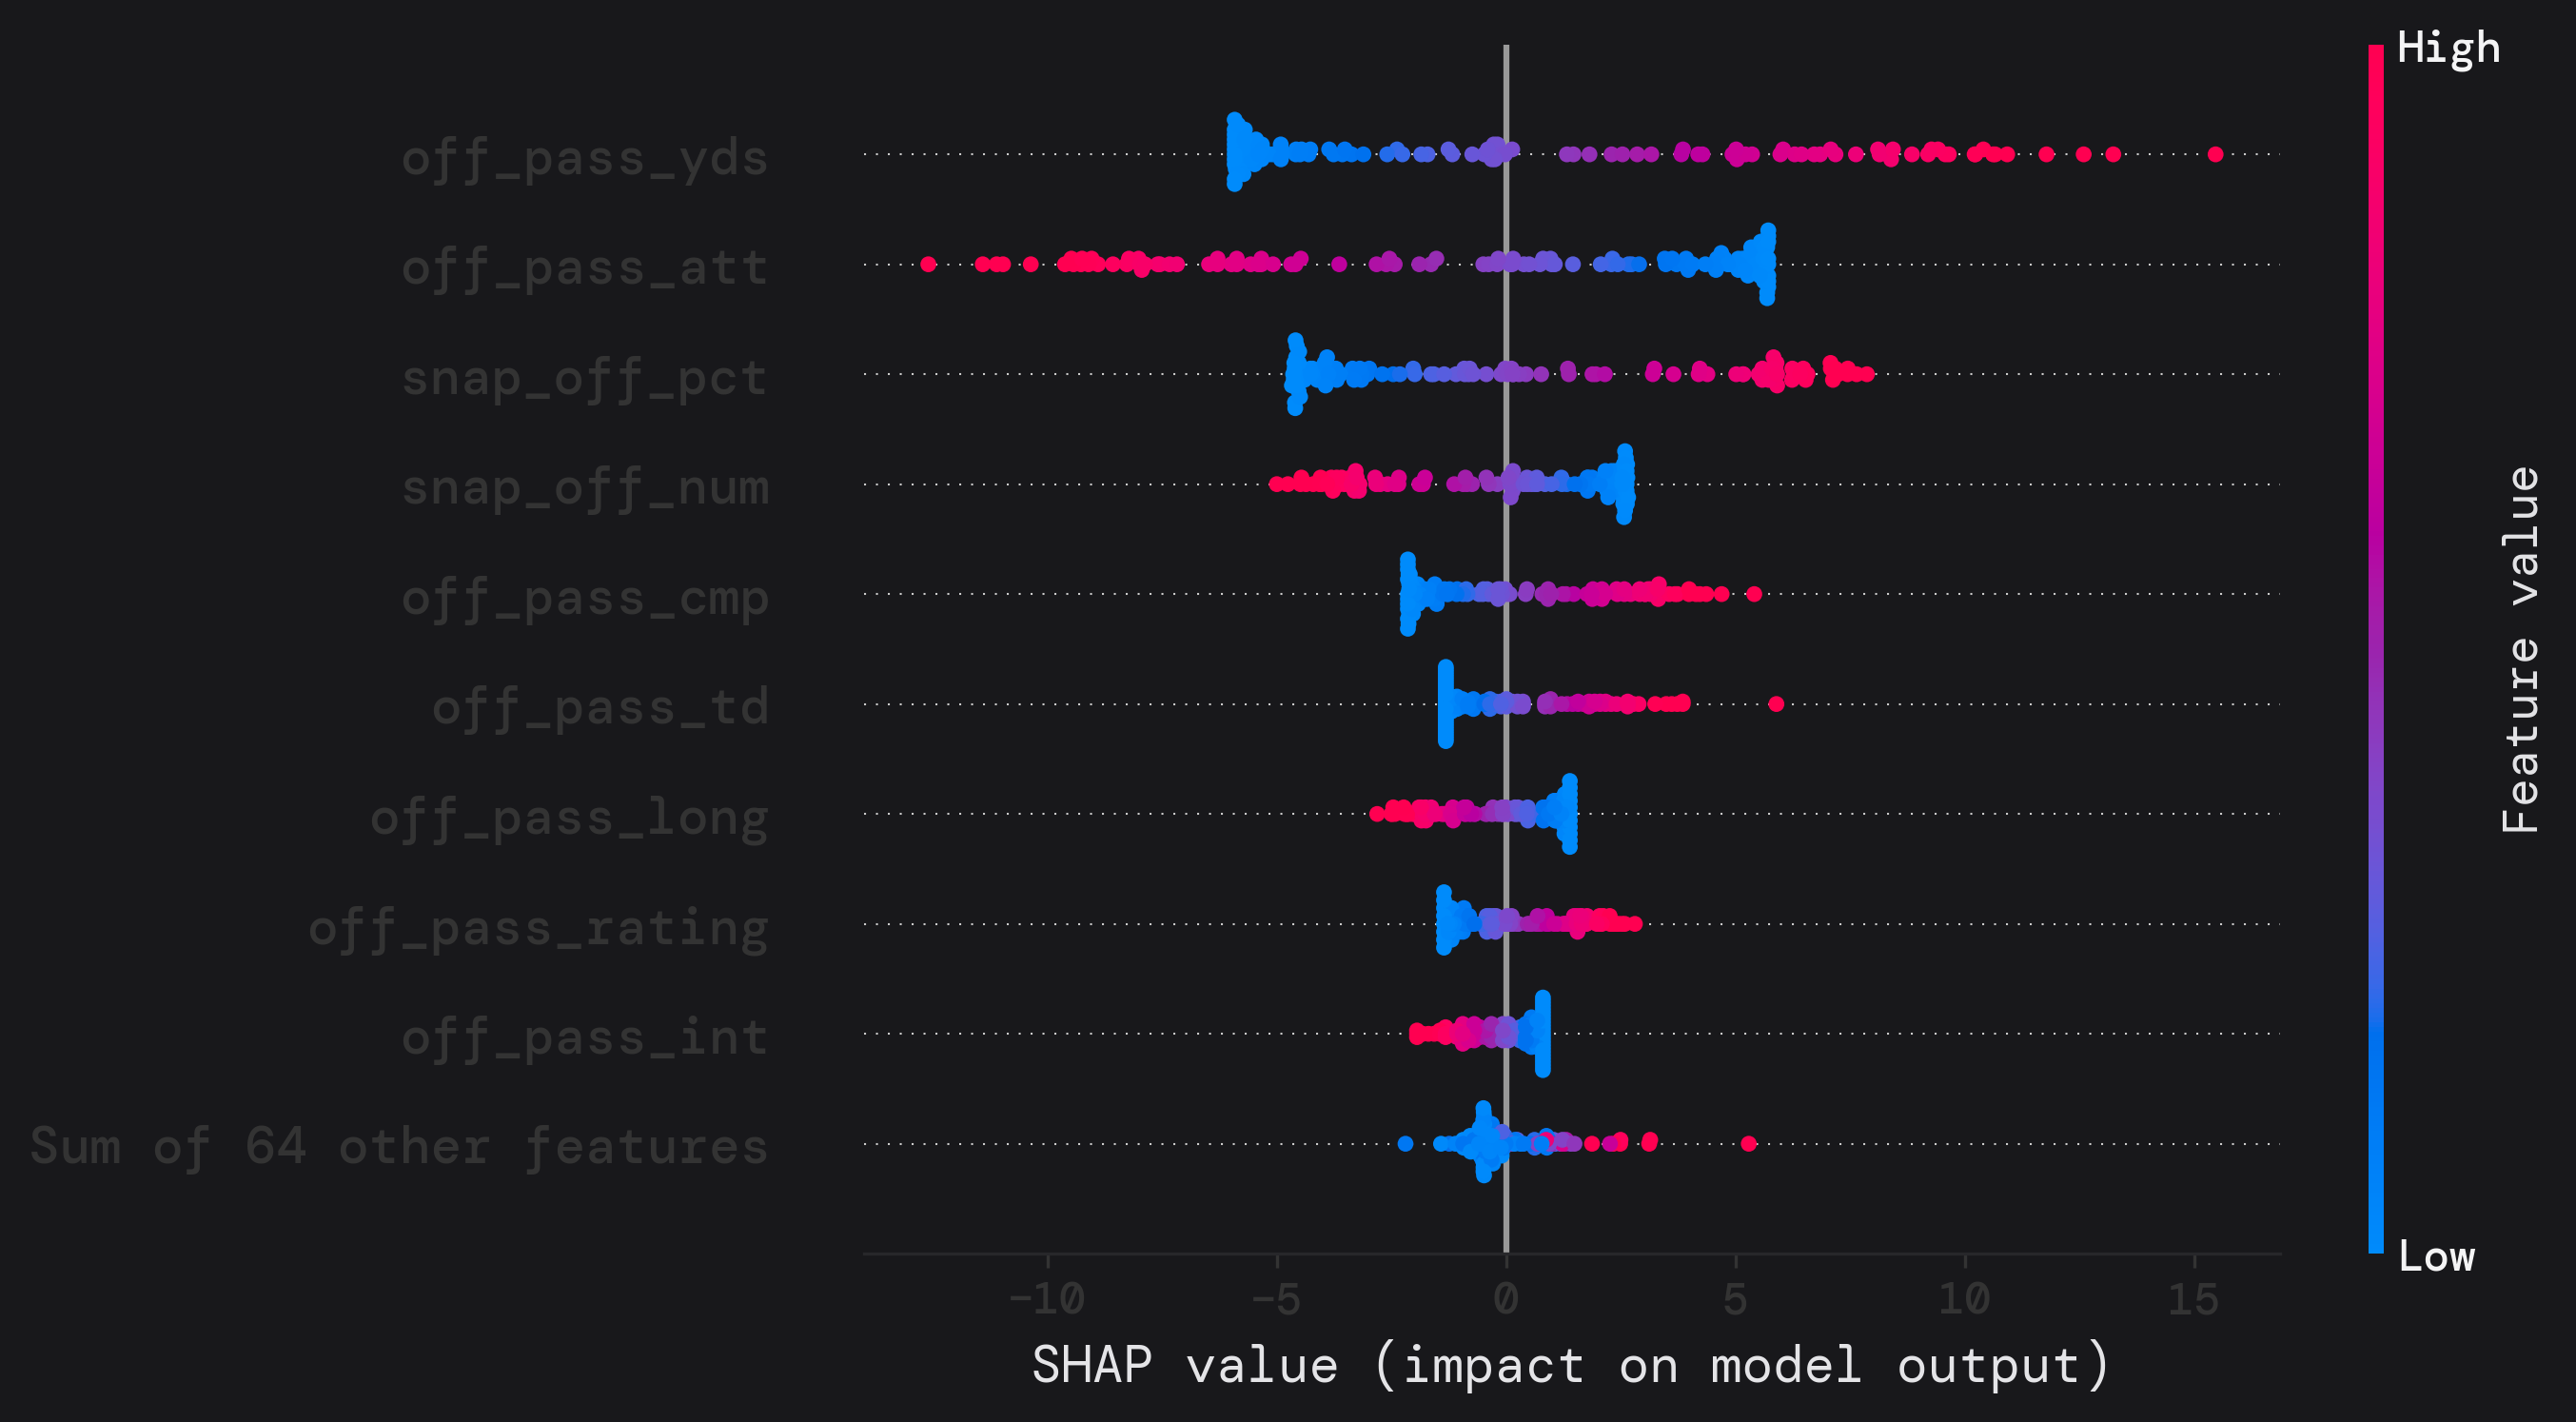

In [41]:
# Overall impact on the final values
shap.plots.beeswarm(shap_values)

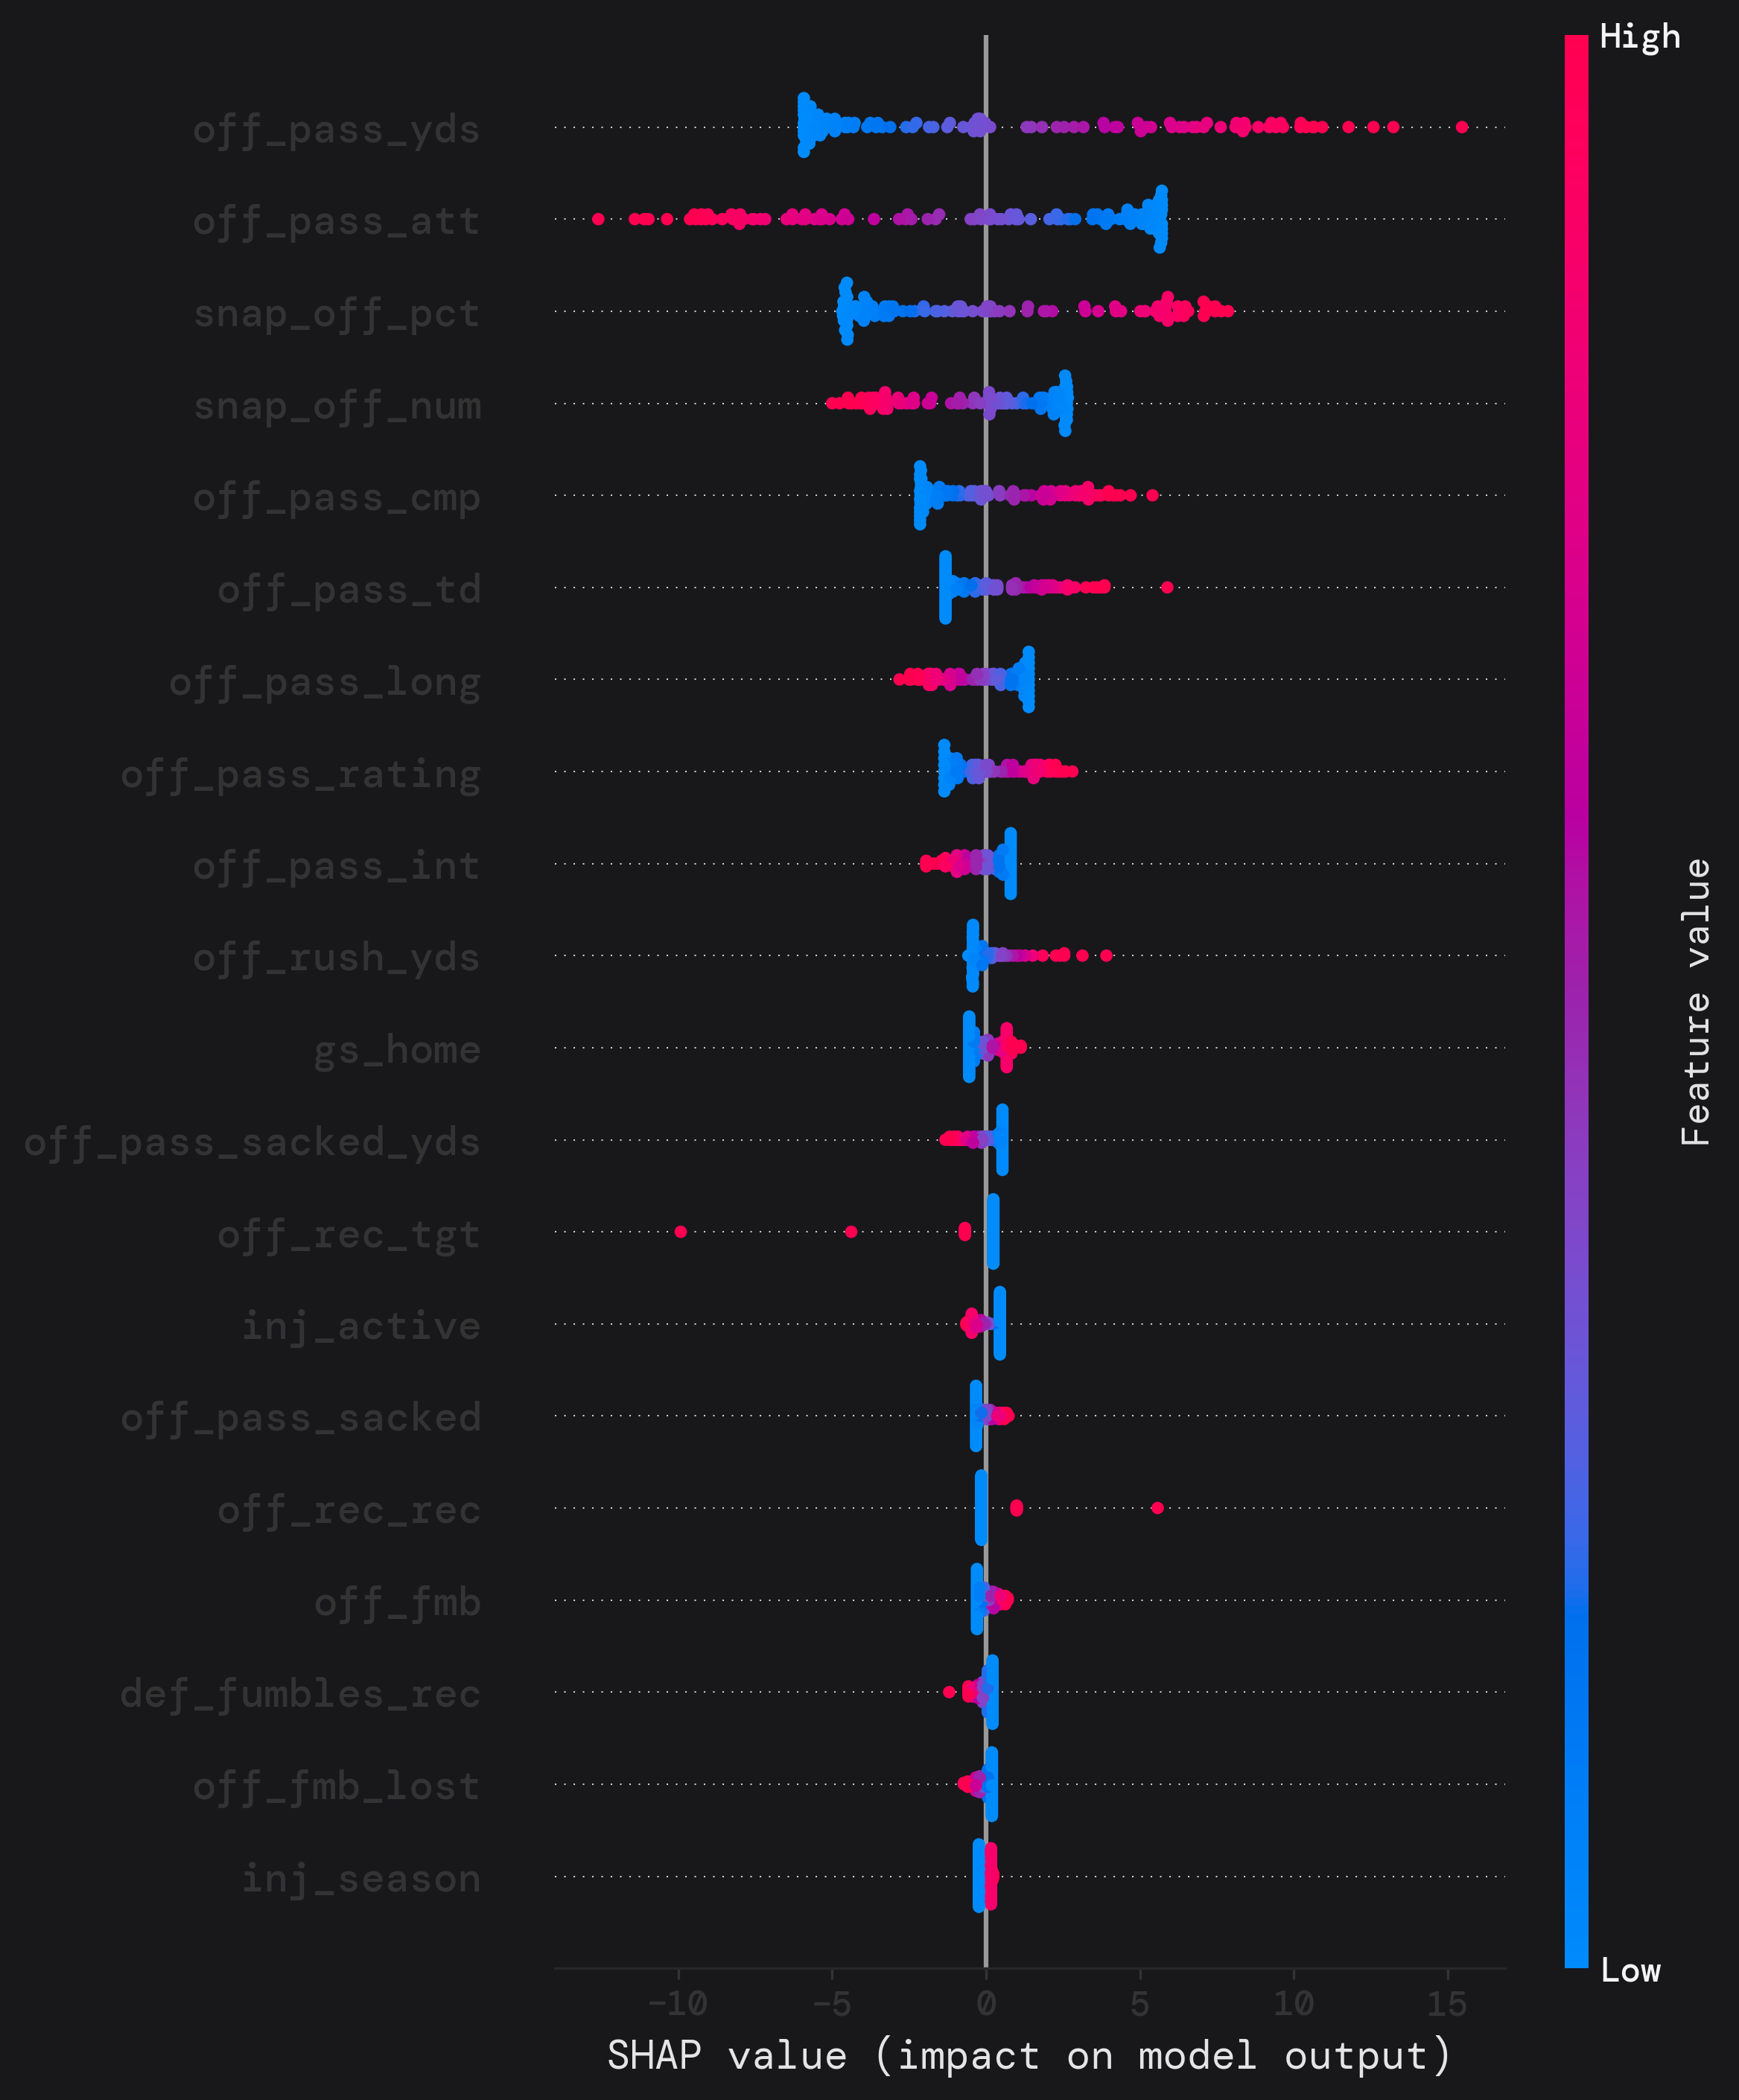

In [44]:
shap.summary_plot(shap_values, qb_stats_train)

## SHAP Review
SHAP tells us for a single data point, in this instance, in the training set, how impactful is each feature towards the over final weight.

For a quarterback, it makes sense - it's offensive passing yards and offensive passing attempts, while it's not necessary to show each of these, we'll take a look at the top 2 features for every position.

In [43]:
def shap_plot_by_position(position: str) -> None:
    """Loads the stats model associated with the position and saves it to
    data/output/plots/
    """
    pos_model = model_loader(f'data/intermediate/model_ridge__position_{position}__model.pkl')
    pos_train = pd.read_csv(f'data/intermediate/model_ridge__position_{position}__x_train.csv')

    explainer = shap.LinearExplainer(pos_model, pos_train)
    shap_values = explainer(pos_train)

    # Call beeswarm to plot it
    shap.plots.beeswarm(shap_values, show=False)
    plt.savefig(f'shap_summary_{position}_stats.png', dpi=700)

    return None

    
# Loop through each position and store the plot
explainer = shap.LinearExplainer(qb_stats_model, qb_stats_train)
shap_values = explainer(qb_stats_train)
# Overall impact on the final values
shap.plots.beeswarm(shap_values)

TE
DB
PR
RB
P
LB
WR
DL
OL
QB
K


In [2]:
with open('data/model/ridge_position_stats.pkl', 'rb') as f:
    model_ridge_stats = pickle.load(f)

ridge_x_test = pd.read_csv('data/intermediate/model_ridge__position__x_test.csv')
#ridge_train_stats = pd.read_csv('../data/output/ridge_position_stats.csv')

try:
    ridge_x_test.drop(columns=['Unnamed: 0'], inplace=True)
    #reg_x_test.drop(columns=['Unnamed: 0'], inplace=True)
except KeyError:
    print(f'{ridge_x_test.shape[1]} columns in test set. No unnamed column')
except Exception as e:
    print(f'Some other error: {e}')
    pass
    

In [3]:
# Model loads for the supervised regression
with open('data/model/gradient_boosted_model.pkl', 'rb') as f:
    model_gbr = pickle.load(f)

with open('data/model/random_forest_model.pkl', 'rb') as f:
    model_rfr = pickle.load(f)


In [4]:
# Specify our regression training and test set for SHAP
roof_dict = {
   'outdoors': 1,
   'dome': 2,
   'retractable roof (closed)': 3,
   'retractable roof (open)': 4
}
reg_x_train = pd.read_csv('data/intermediate/model_rfr__x_train.csv')
reg_x_test = pd.read_csv('data/intermediate/model_rfr__x_test.csv')
reg_x_train['roof_type'] = reg_x_train['roof_type'].map(roof_dict.get)

try:
    reg_x_test.drop(columns=['Unnamed: 0'], inplace=True)
except KeyError:
    print(f'{reg_x_test.shape[1]} columns in test set. No "Unnamed: 0" column')
except Exception as e:
    print(f'Some other error: {e}')
    pass

14 columns in test set. No "Unnamed: 0" column


# SHAP Regression Explanation
## Explaining Weights for the Player Stats (Ridge Regression)

The player ranking alogorithm is made up of reading in all the different stats that are recorded in `PlayerStats`. This is fit using the years 2013-2014 (inclusive). In doing so, we are able to able to generate weights appropriate to then rank players afterwards.

By exposing the test and training data, we can better understand how the model views different features of importance through the use of `SHAP`.

We'll first read in the model via `shap.LinearExplainer`. 

In [5]:
explainer = shap.LinearExplainer(model_ridge_stats, ridge_x_test)
shap_values = explainer(ridge_x_test)
print(f'Shape of our data: {ridge_x_test.shape}')

Shape of our data: (132, 73)


In [12]:
ridge_x_test

,snap_off_num,snap_off_pct,snap_def_num,snap_def_pct,snap_st_num,snap_st_pct,gs_home,inj_season,def_def_int,def_def_int_yds,...,inj_game_status_out,inj_game_status_probable,inj_game_status_doubtful,inj_game_status_injured_reserve,inj_game_status_questionable,inj_game_status_unable_to_perform,inj_game_status_suspended,inj_game_status_day_to_day,inj_game_status_reserve,inj_game_status_unknown
0,0.0,0.0,547.0,8.81,66.0,2.42,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,696.0,9.91,55.0,1.88,7.0,32208.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,960.0,14.40,33.0,1.22,8.0,34221.0,1.0,7.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,46.0,0.78,95.0,3.57,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,527.0,7.75,111.0,3.86,6.0,38266.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.0,0.0,732.0,10.02,70.0,2.47,8.0,32224.0,0.0,0.0,...,0.0,8.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
128,0.0,0.0,591.0,8.72,196.0,6.94,0.0,36252.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
129,0.0,0.0,247.0,3.76,123.0,4.23,0.0,32224.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
130,0.0,0.0,504.0,7.31,90.0,3.07,7.0,32224.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


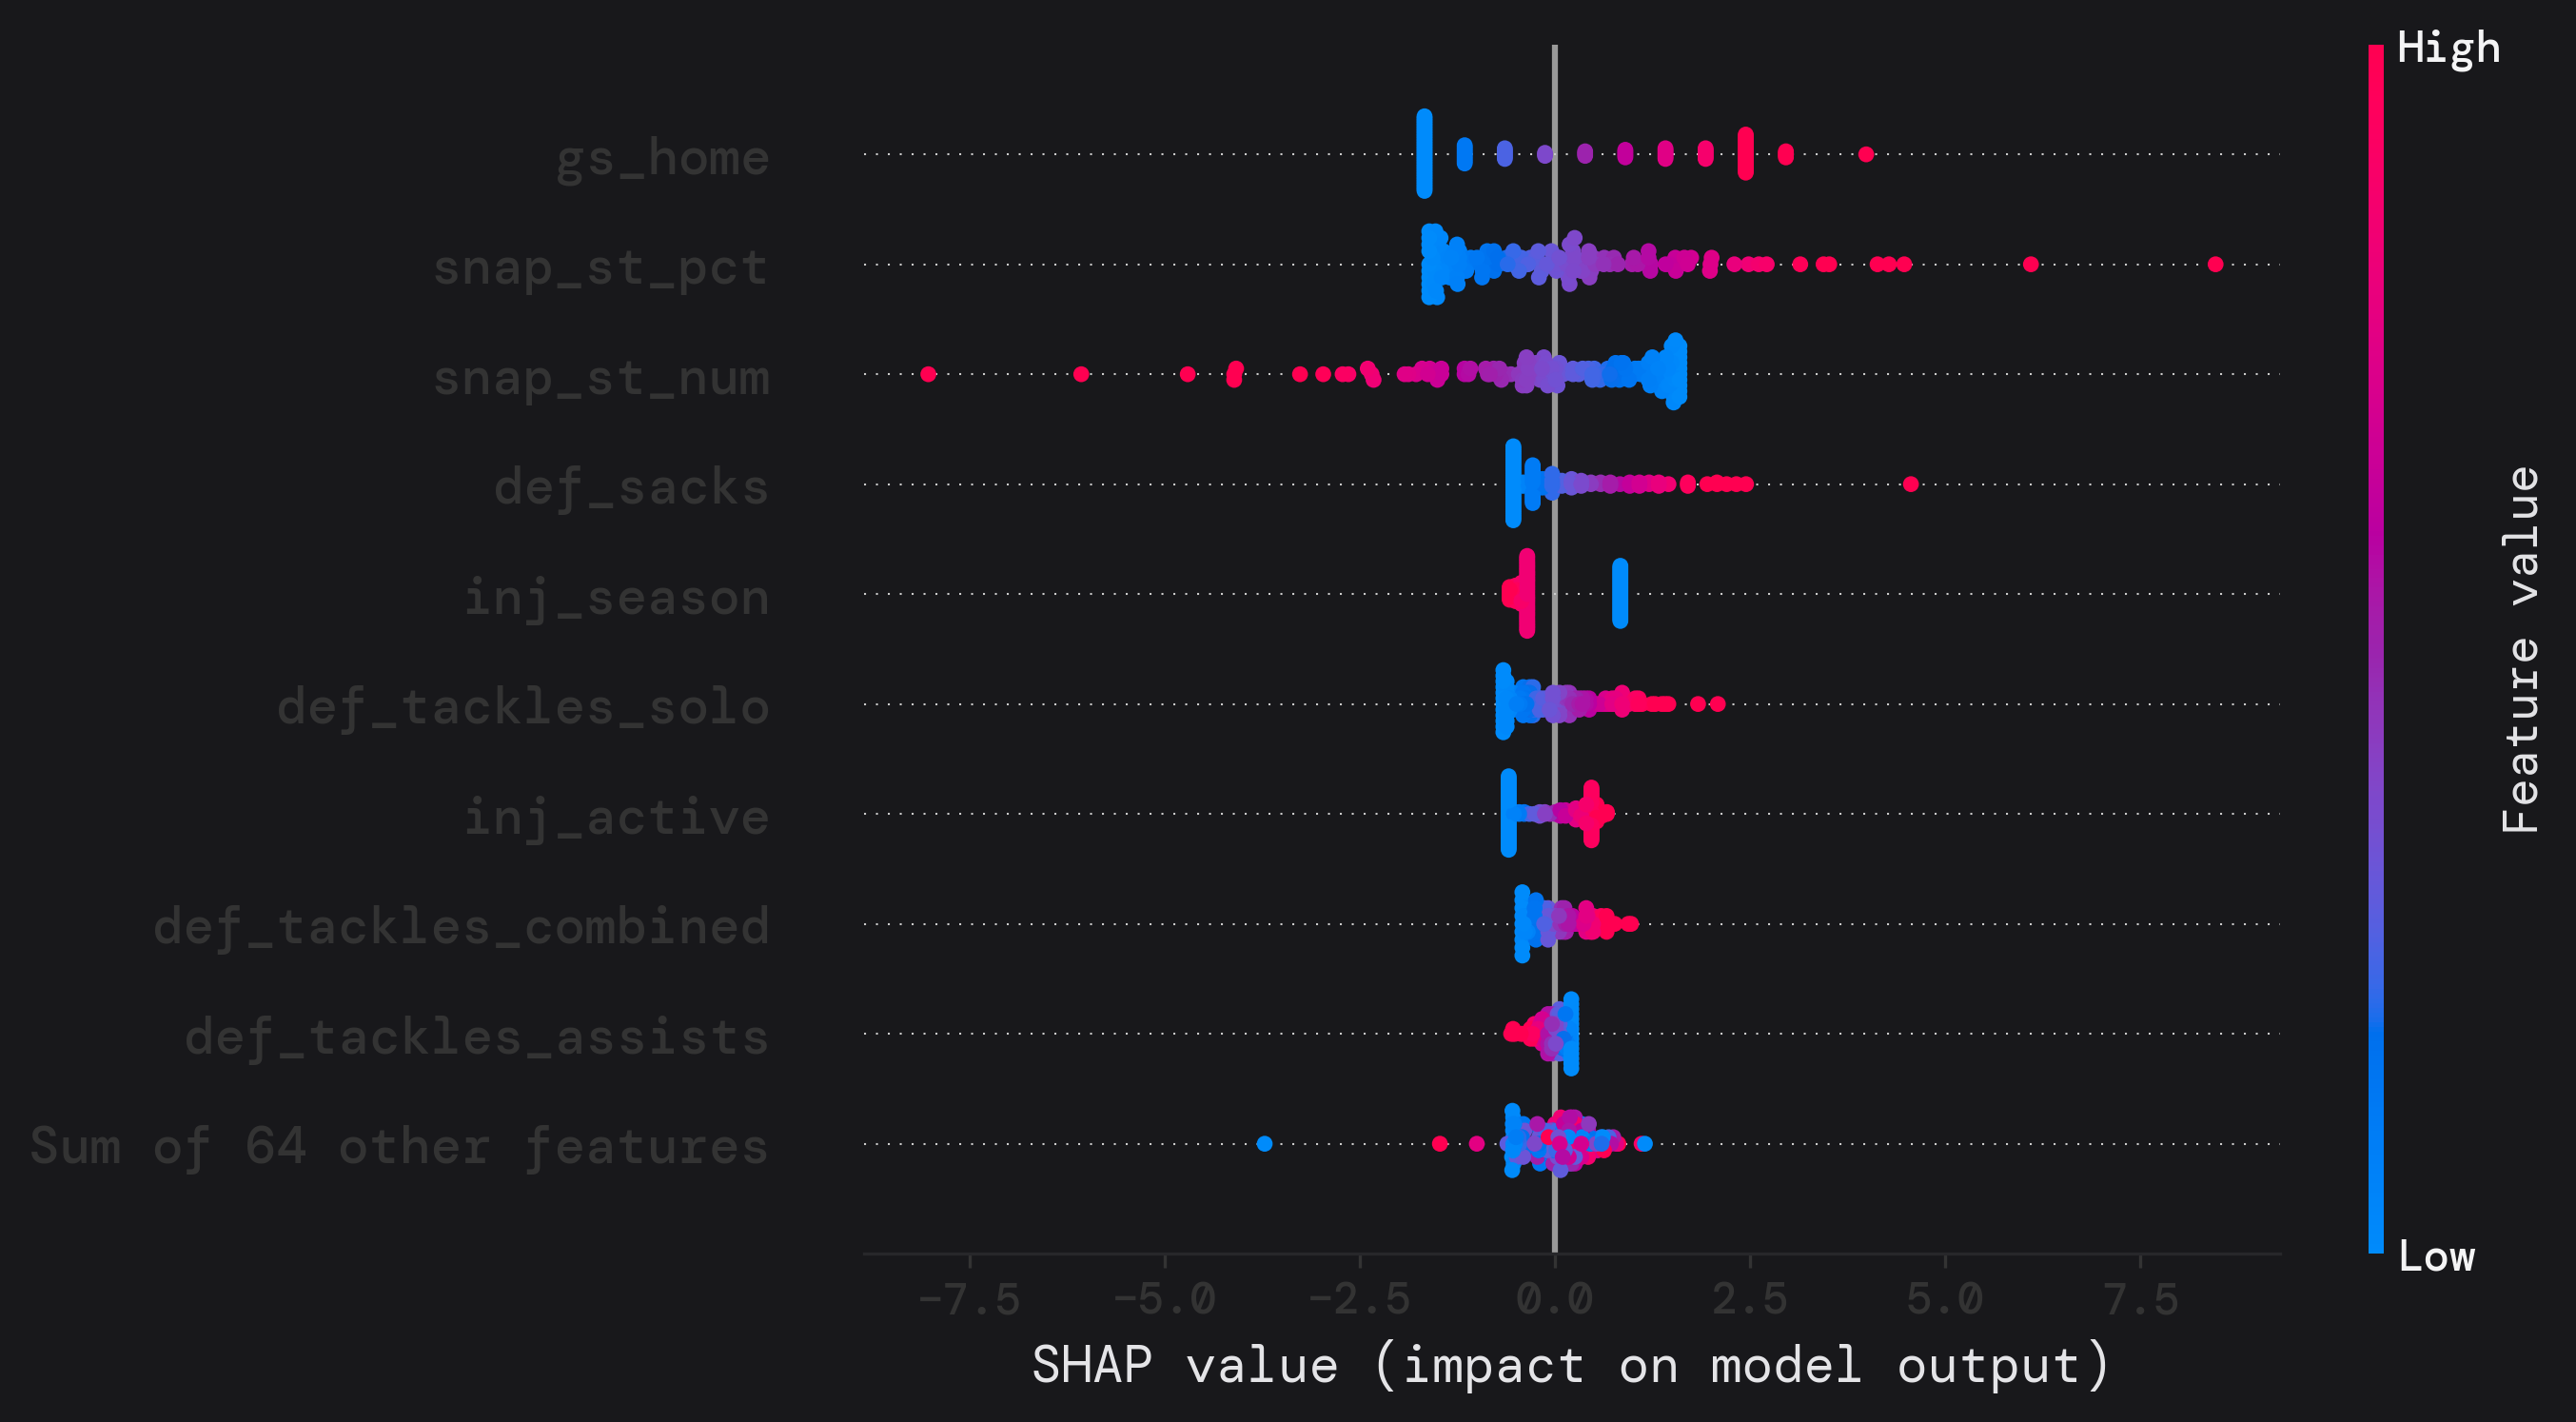

In [6]:
# Overall impact on the final values
shap.plots.beeswarm(shap_values)

# SHAP Position Score
We can break this down further to understand what the different coluns mean. First we must understand what we are predicting. These are the weights used to determine how much a specific stat influences an overall player's ranking, per game. The top factor for `

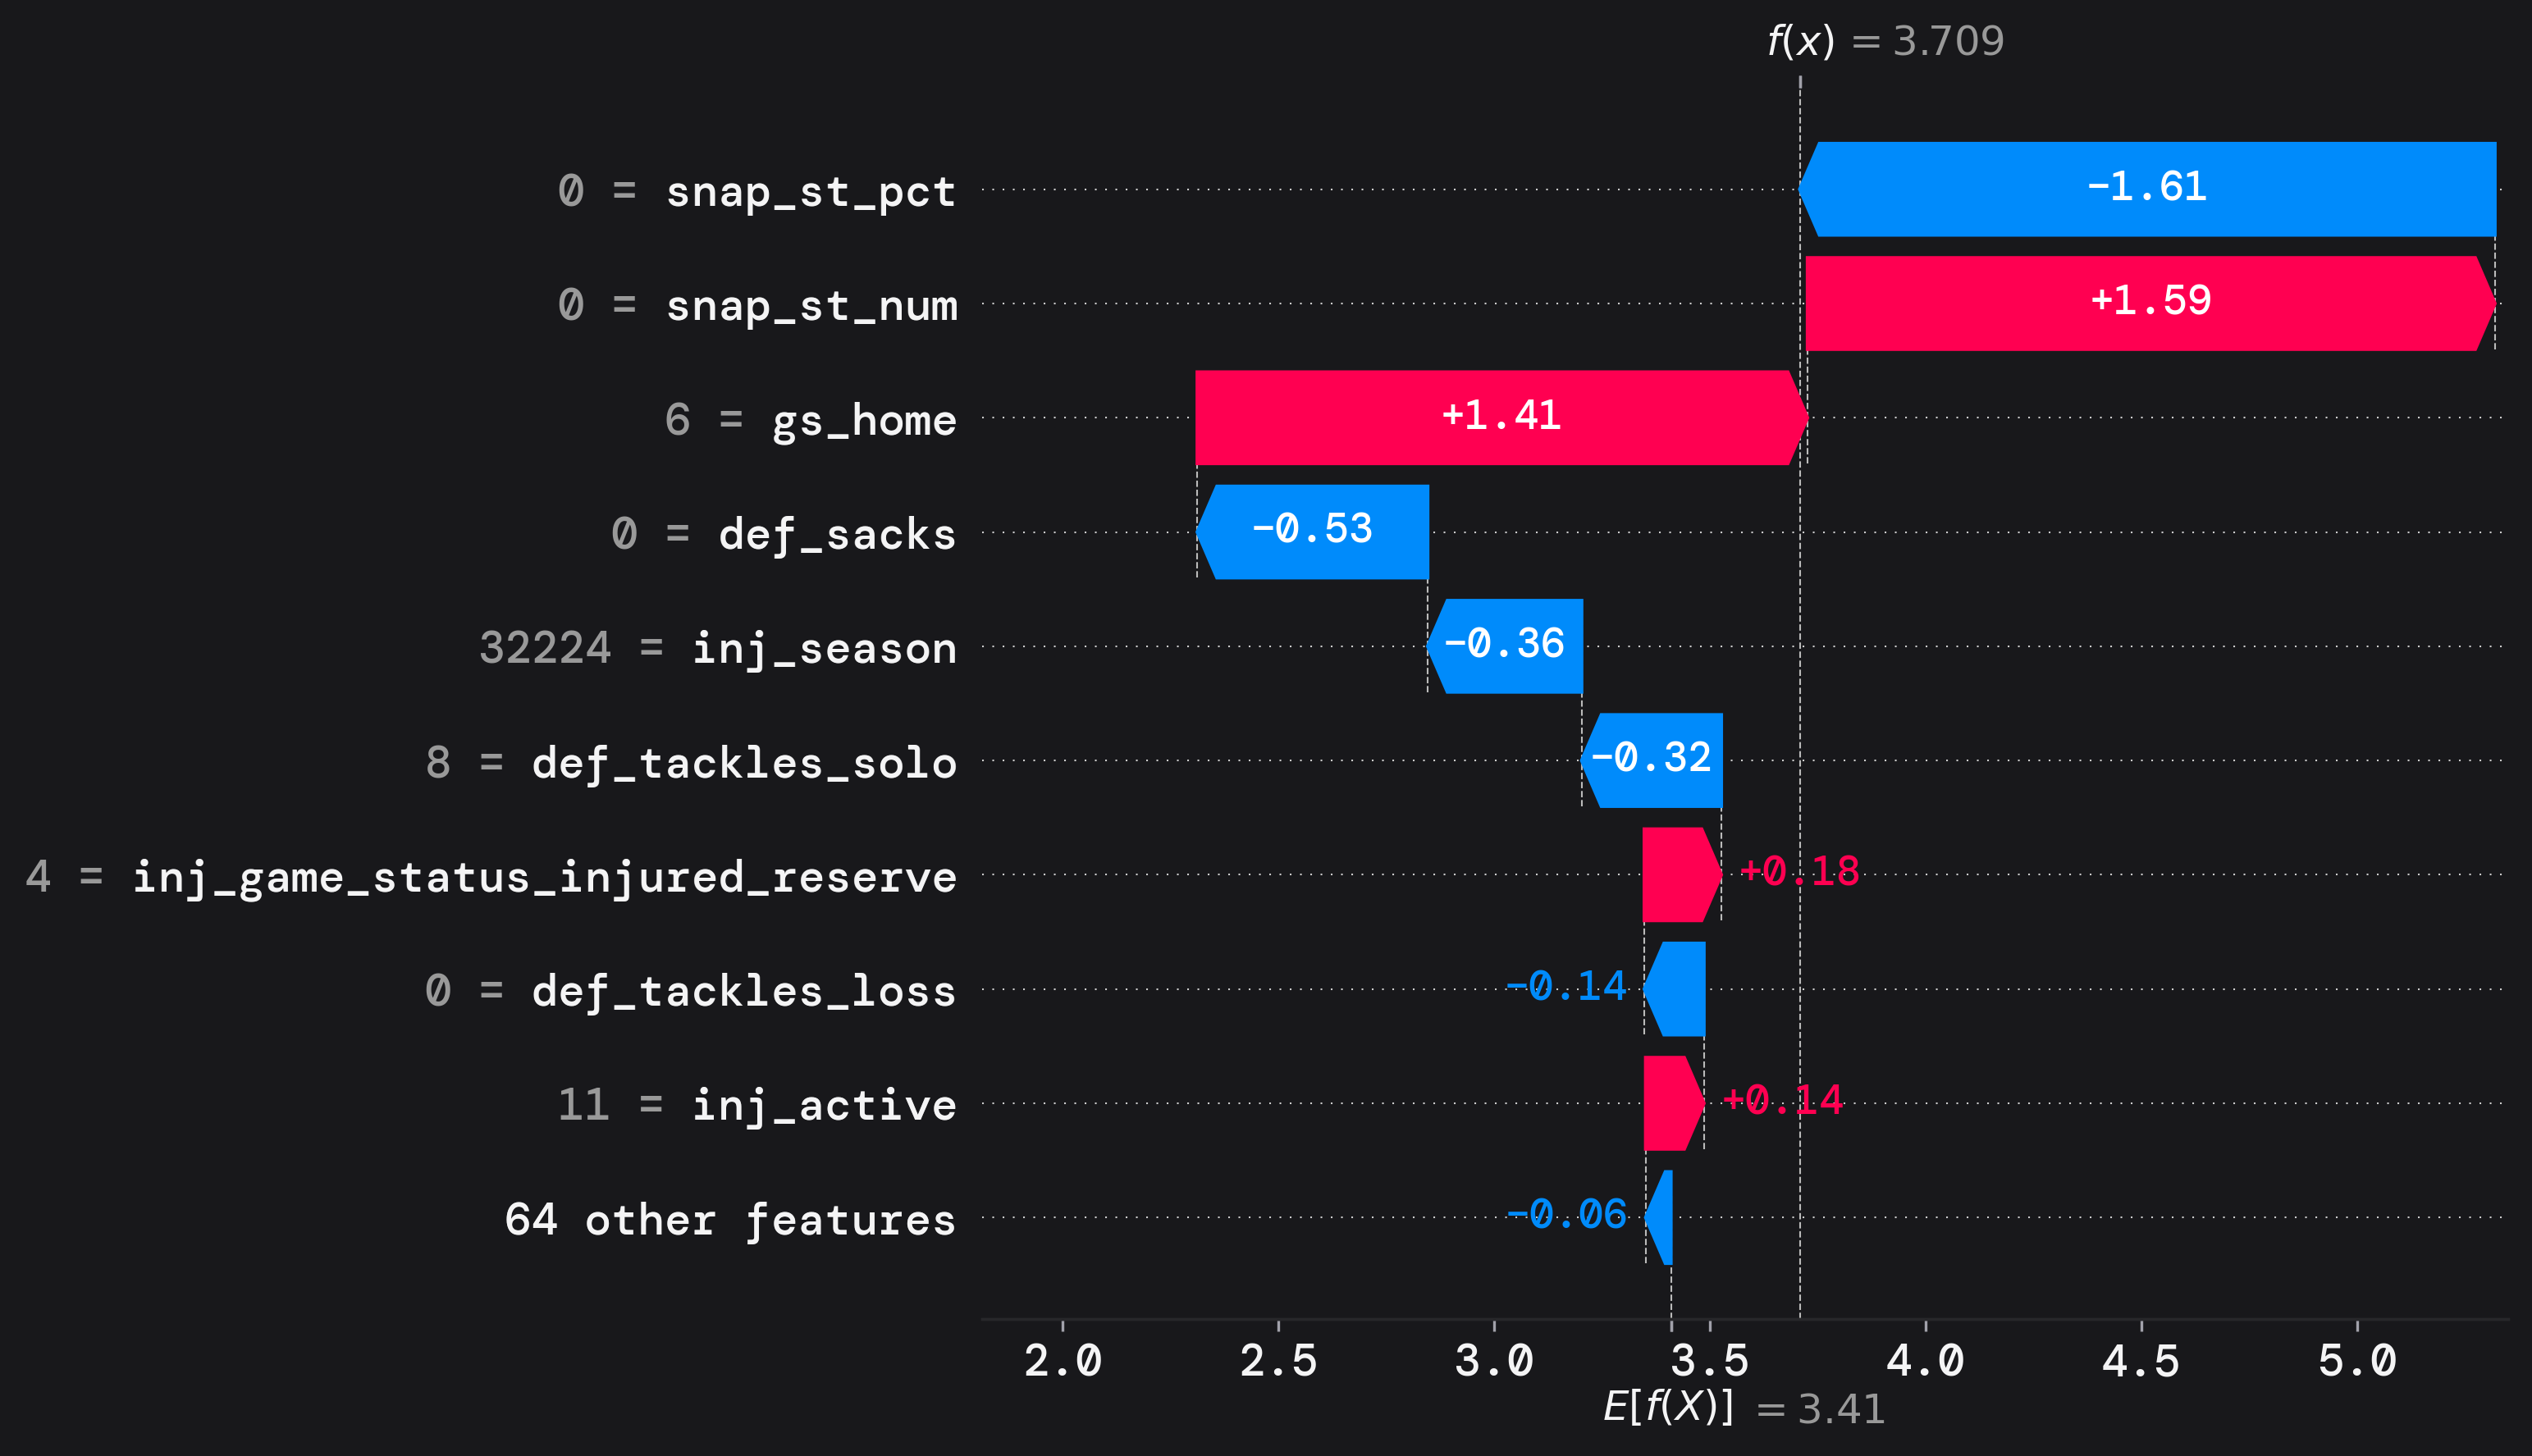

In [9]:
shap.plots.waterfall(shap_values[42])

In [10]:
# Random Forest Explainer
rfr_explainer = build_explainer(model_rfr.best_estimator_['regressor'])
rfr_shap_values = rfr_explainer.shap_values(np.array(reg_x_train.sample(100)), check_additivity=False)


In [10]:
# This is to print the JS visualization code to the notebook
shap.initjs()
#shap.plots.beeswarm(rfr_shap_values

In [11]:
rfr_results = pd.read_csv('data/output/random_forest_model_output.csv')

In [12]:
# Adding in some evaluation metrics
def game_outcome(team_a_score: float, team_b_score: float) -> str:
    """Compares the home team's score against the opponents
    Returns either a 'w' or a 'l'
    """
    if team_a_score > team_b_score:
        return "w"
    elif team_b_score > team_a_score:
        return "l"
    else:
        return "t"
    

rfr_results['home_result_actual'] = rfr_results[['score_home_test', 'score_opp_test']].apply(lambda row: game_outcome(row['score_home_test'], row['score_opp_test']), axis=1)
rfr_results['opp_results_actual'] = rfr_results[['score_opp_test', 'score_home_test']].apply(lambda row: game_outcome(row['score_opp_test'], row['score_home_test']), axis=1)
rfr_results['home_results_pred'] = rfr_results[['score_home_pred', 'score_opp_pred']].apply(lambda row: game_outcome(row['score_home_pred'], row['score_opp_pred']), axis=1)
rfr_results['opp_results_pred'] = rfr_results[['score_opp_pred', 'score_home_pred']].apply(lambda row: game_outcome(row['score_opp_pred'], row['score_home_pred']), axis=1)

rfr_results['spread_actual'] = rfr_results['score_home_test'] - rfr_results['score_opp_test']
rfr_results['spread_pred'] = rfr_results['score_home_pred'] - rfr_results['score_opp_pred']
rfr_results['home__abs_residual'] = abs(rfr_results['score_home_test'] - rfr_results['score_home_pred'])
rfr_results['opp__abs_residual'] = abs(rfr_results['score_opp_test'] - rfr_results['score_opp_pred'])
rfr_results['home__game_mape'] = rfr_results['home__abs_residual']/rfr_results['score_home_test']
rfr_results['opp__game_mape'] = rfr_results['opp__abs_residual']/rfr_results['score_opp_test']
rfr_results['']

rfr_results.head()

,Unnamed: 0,game_id,boxscore_stub,week_ind,day_int,OT,away,attendance,roof_type,humidity_pct,...,home_result_actual,opp_results_actual,home_results_pred,opp_results_pred,spread_actual,spread_pred,home__abs_residual,opp__abs_residual,home__game_mape,opp__game_mape
0,2173,nyj_buf_2023-09-11,/boxscores/202309110nyj.htm,1.0,1,1,1,83345.0,outdoors,88.0,...,w,l,l,w,6.0,-9.774,5.864,9.910,0.266545,0.619375
1,2174,buf_rai_2023-09-17,/boxscores/202309170buf.htm,2.0,2,0,0,70772.0,outdoors,57.0,...,w,l,w,l,28.0,14.866,12.601,0.533,0.331605,0.053300
2,2175,was_buf_2023-09-24,/boxscores/202309240was.htm,3.0,2,0,1,64291.0,outdoors,96.0,...,l,w,l,w,-34.0,-3.256,15.541,15.203,5.180333,0.410892
3,2176,buf_mia_2023-10-01,/boxscores/202310010buf.htm,4.0,2,0,0,70881.0,outdoors,71.0,...,w,l,w,l,28.0,5.106,19.271,3.623,0.401479,0.181150
4,2177,buf_jax_2023-10-08,/boxscores/202310080buf.htm,5.0,2,0,0,61273.0,outdoors,52.0,...,l,w,l,w,-5.0,-0.410,4.829,0.239,0.241450,0.009560


<Axes: xlabel='home_strength', ylabel='opp_strength'>

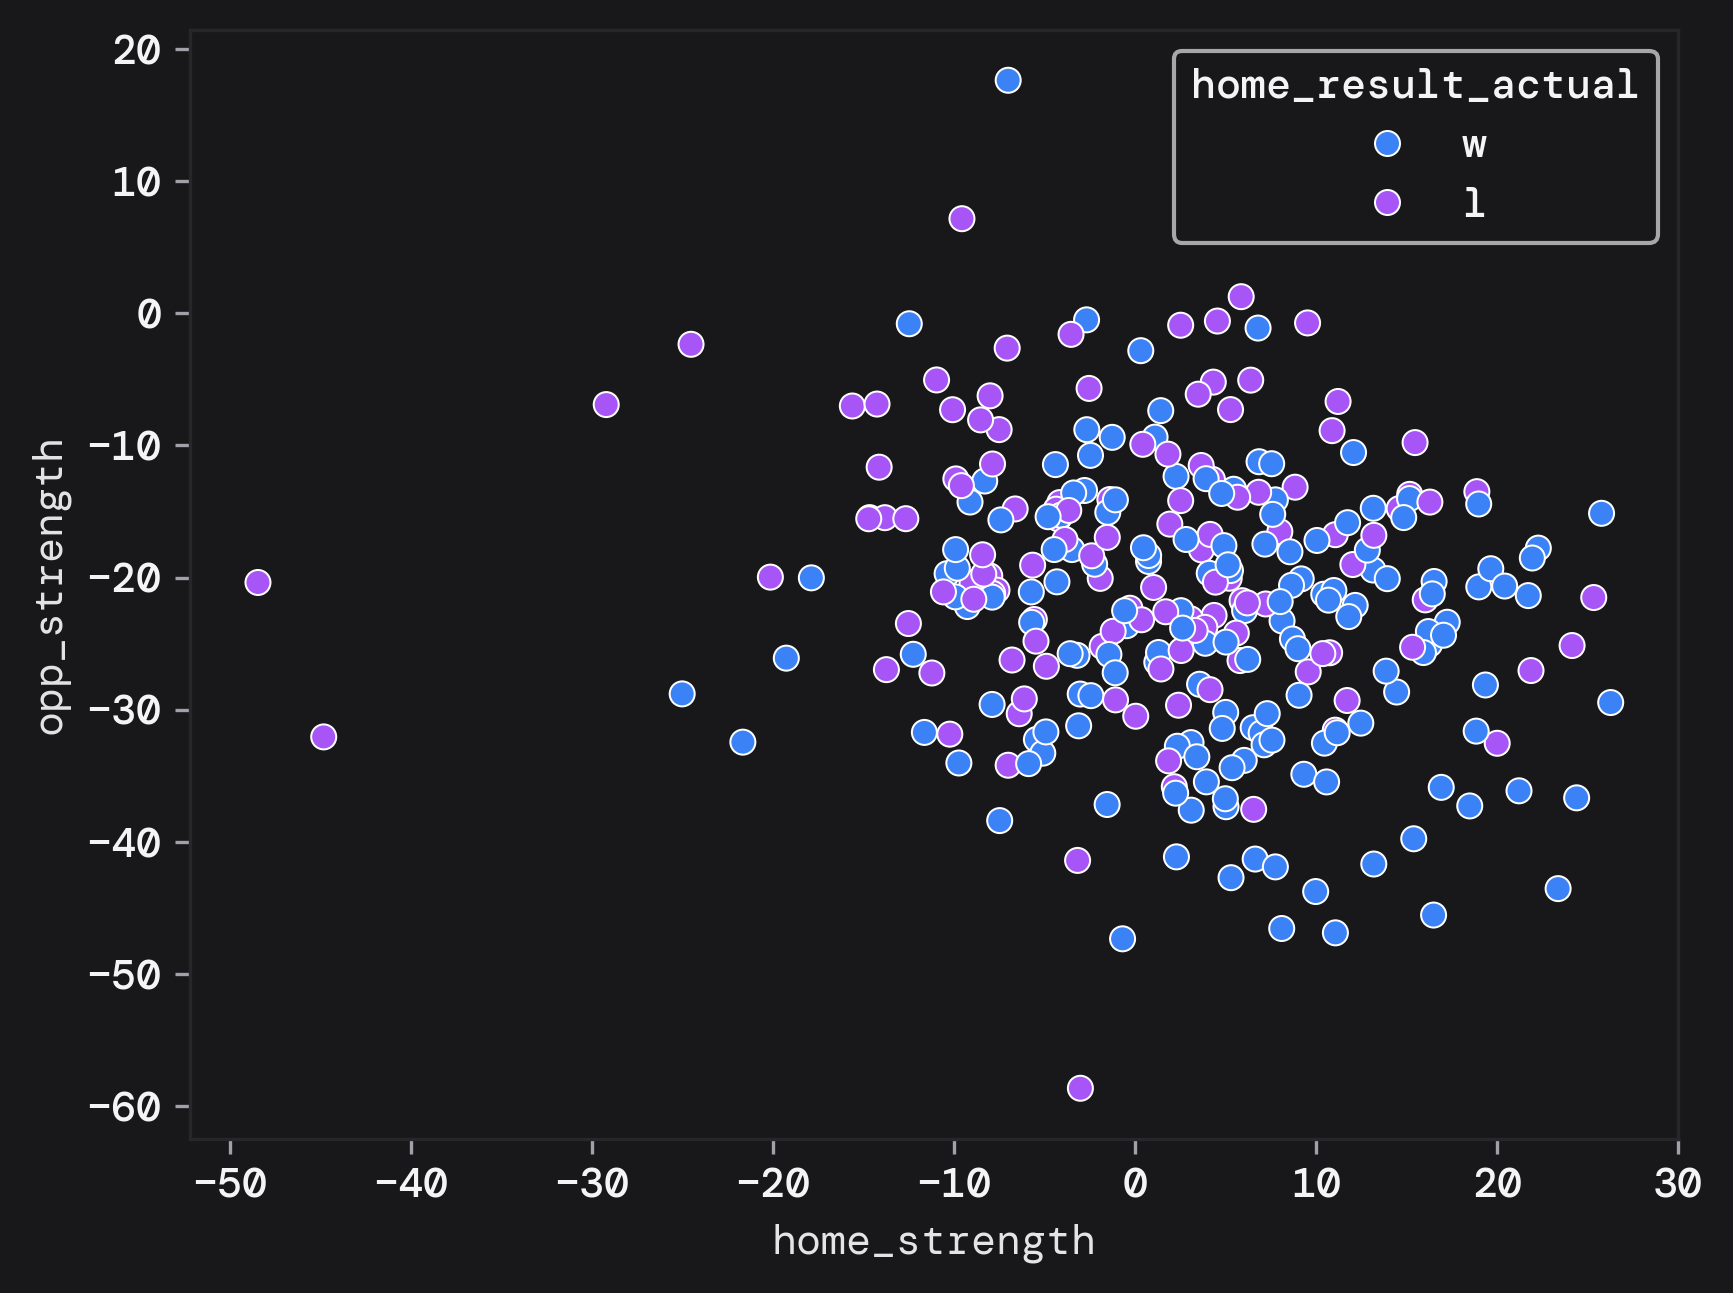

In [13]:
#sns.set_theme(style)

sns.scatterplot(data=rfr_results, x='home_strength', y = 'opp_strength', hue='home_result_actual')

<Axes: xlabel='home_strength', ylabel='score_home_test'>

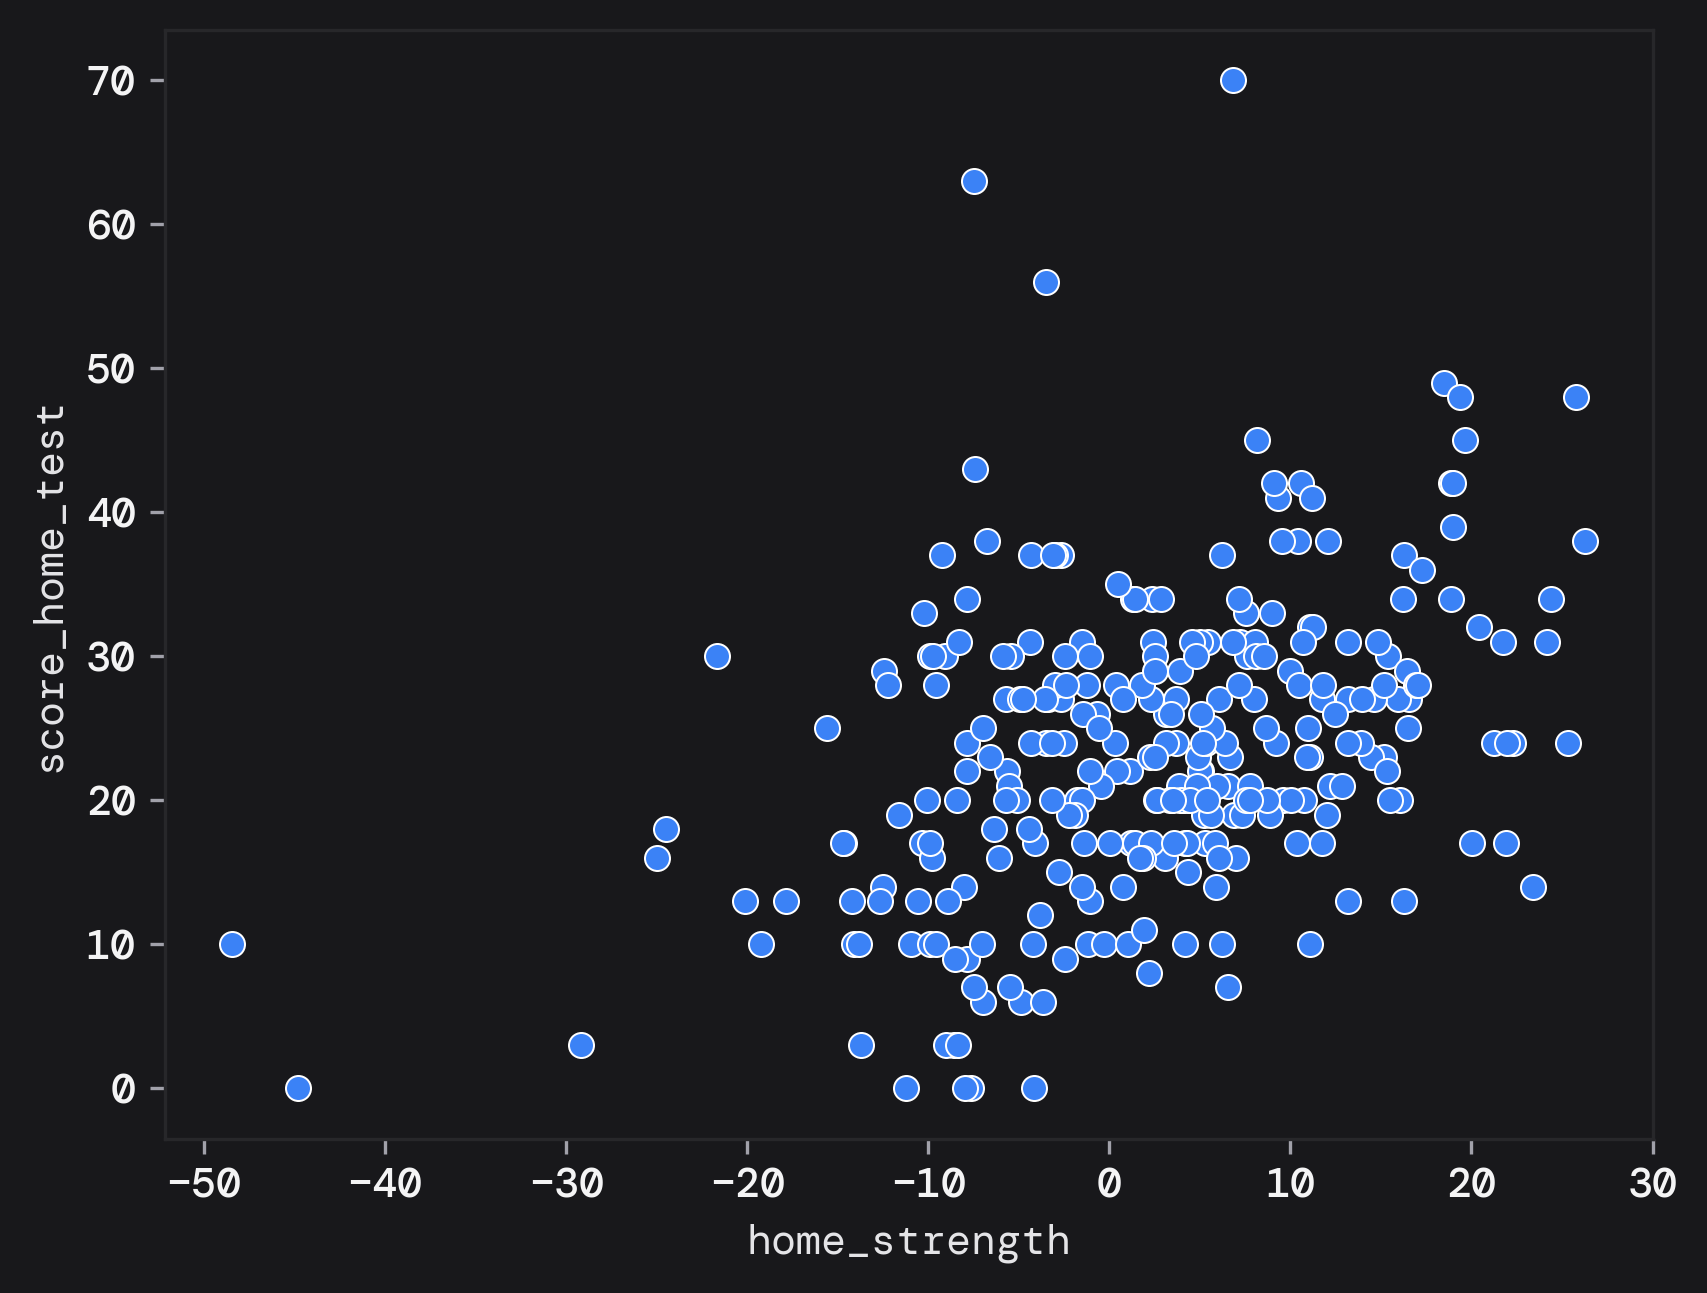

In [15]:
sns.scatterplot(data=rfr_results, y='score_home_test', x = 'home_strength')

In [ ]:
sns.pairplot(rfr_results, hue=)